# Function Approximation in RL - LSTD(lambda)

**Due date : 20/03/2018**

**By : Julien Roy and David Kanaa**

In [1]:
import gym
import time

import numpy as np
import pycolab

from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites

from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction

# Implementations

In [2]:
def show_board(obs, board_memory=None):
    
    board = 10 * np.array(obs.layers['P'], dtype=np.float)
    new_memory = 2.5 * np.array(obs.layers['P'], dtype=np.float)
    
    if board_memory is not None:
        board_memory += new_memory
        board += board_memory
    else:
        board_memory = new_memory
    
    board += 8 * np.array(obs.layers['G'], dtype=np.float)

    plt.figure()
    plt.imshow(board)
    plt.axis('off')
    plt.show()
    
    return board_memory

### Environment - Boyan's Chain

In [11]:
BOYAN_CHAIN = ['P            G']

def make_BoyanChain(art):
    """Builds and returns game."""
    return ascii_art.ascii_art_to_game(art, what_lies_beneath=' ', sprites={'P': PlayerSprite_BoyanChain})

class PlayerSprite_BoyanChain(prefab_sprites.MazeWalker):

    def __init__(self, corner, position, character):
        """Inform superclass that the '#' delimits the walls."""
        super(PlayerSprite_BoyanChain, self).__init__(corner, position, character, impassable='#')
    
    def update(self, actions, board, layers, backdrop, things, the_plot):
        del backdrop, things   # Unused in this application.
        _, position = self.position
        
        if actions == 0: # Just to avoid making a move during its_showtime() call
            
            # From the last state before the Goal
            if layers["G"][0, position + 1]:
                self._east(board, the_plot)   # single jump east
                the_plot.add_reward(-2.0)

            # From any other state 
            else:
                # Each one of the 2 possible transitions have a probability of 0.5
                if np.random.rand() > 0.5:    # single jump east
                    self._east(board, the_plot)
                else:                         # double jump east
                    self._east(board, the_plot)
                    self._east(board, the_plot)

                # Any transition from those states give a reward of -3
                the_plot.add_reward(-3.0)
                 
        
        # Check if our agent is on the goal position
        if layers["G"][self.position]:
            the_plot.terminate_episode()

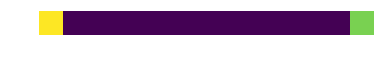

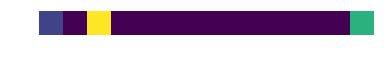

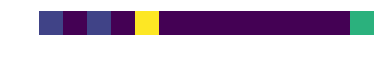

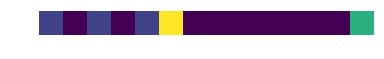

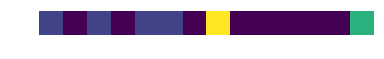

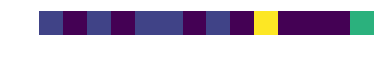

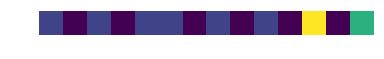

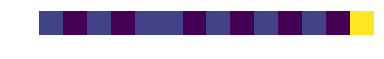

GAME OVER
Undiscounted Return : -21.0


In [12]:
undiscounted_return = 0

game = make_BoyanChain(BOYAN_CHAIN)
obs, reward, gamma = game.its_showtime()
board_memory = show_board(obs)
while not(game.game_over):
    obs, reward, gamma = game.play(0)
    undiscounted_return += reward
    board_memory = show_board(obs, board_memory)
print('GAME OVER')
print('Undiscounted Return : {}'.format(undiscounted_return))

### Environment - Bradtke's 5-states Domain

(I think this should be implemented as a Gym environment..?)

# Experiments

# Discussion

# Conclusion